In [41]:
# Data analsis
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import  warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Data moduling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [5]:


heart_data = pd.read_csv('heart.csv')
pd.set_option('display.max.columns', None)
heart_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
heart_data.info()
heart_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


(918, 12)

In [7]:
missing_values = heart_data.isnull().sum().sort_values(ascending=False)

missing_values[missing_values > 0]


Series([], dtype: int64)

In [8]:

duplicates = heart_data.duplicated().sum()
if duplicates > 0:
    print(f"Найдено {duplicates} дубликатов.")


In [9]:

negative_values = {}
for col in heart_data.select_dtypes(include=['float64', 'int64']).columns:
    if (heart_data[col] < 0).any():
        negative_values[col] = heart_data[col][heart_data[col] < 0].count()

unrealistic_values = {
    "Age": heart_data[heart_data["Age"] > 120].shape[0],
    "Cholesterol_Zero": heart_data[heart_data["Cholesterol"] == 0].shape[0],
    "RestingBP_Low": heart_data[heart_data["RestingBP"] < 50].shape[0],
    "RestingBP_High": heart_data[heart_data["RestingBP"] > 200].shape[0]
}

invalid_categorical = {}
for col in ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']:
    invalid_values = heart_data[col].unique()
    invalid_categorical[col] = invalid_values

binary_issues = {
    "FastingBS": set(heart_data["FastingBS"].unique()) - {0, 1},
    "HeartDisease": set(heart_data["HeartDisease"].unique()) - {0, 1}
}

negative_values, unrealistic_values, invalid_categorical, binary_issues


({'Oldpeak': 13},
 {'Age': 0, 'Cholesterol_Zero': 172, 'RestingBP_Low': 1, 'RestingBP_High': 0},
 {'Sex': array(['M', 'F'], dtype=object),
  'ChestPainType': array(['ATA', 'NAP', 'ASY', 'TA'], dtype=object),
  'RestingECG': array(['Normal', 'ST', 'LVH'], dtype=object),
  'ExerciseAngina': array(['N', 'Y'], dtype=object),
  'ST_Slope': array(['Up', 'Flat', 'Down'], dtype=object)},
 {'FastingBS': set(), 'HeartDisease': set()})

In [10]:

cleaned_data = heart_data[(heart_data["Cholesterol"] > 0) & (heart_data["RestingBP"] >= 50)]

print(f"Data size before cleaning: {heart_data.shape}")
print(f"Data size after clean: {cleaned_data.shape}")



Data size before cleaning: (918, 12)
Data size after clean: (746, 12)


In [11]:

def detect_outliers_iqr(data, columns):
    outliers = {}
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        print(f"{col}: Found emissions {len(outliers[col])}")
    
    return outliers

numeric_columns = cleaned_data.select_dtypes(include=['float64', 'int64']).columns

outliers_iqr = detect_outliers_iqr(cleaned_data, numeric_columns)


Age: Found emissions 0
RestingBP: Found emissions 20
Cholesterol: Found emissions 23
FastingBS: Found emissions 125
MaxHR: Found emissions 0
Oldpeak: Found emissions 15
HeartDisease: Found emissions 0


In [12]:
for col in numeric_columns:
    Q1 = cleaned_data[col].quantile(0.25)
    Q3 = cleaned_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Заменяем выбросы медианным значением
    median = cleaned_data[col].median()
    cleaned_data.loc[(cleaned_data[col] < lower_bound) | (cleaned_data[col] > upper_bound), col] = median


In [13]:
cleaned_data = cleaned_data.drop(columns=["FastingBS"])

# Проверка структуры данных после удаления
cleaned_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,Normal,122,N,0.0,Up,0


In [14]:
label = LabelEncoder()

In [16]:
cleaned_data_object = cleaned_data.select_dtypes(include='object')
cleaned_data_nomric = cleaned_data.select_dtypes(exclude='object')

In [17]:
for i in range(0,cleaned_data_object.shape[1]):
    cleaned_data_object.iloc[:,i] = label.fit_transform(cleaned_data_object.iloc[:,i])

In [18]:
df = pd.concat([cleaned_data_object,cleaned_data_nomric],axis=1)

In [19]:
df.head()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease
0,1,1,1,0,2,40,140,289,172,0.0,0
1,0,2,1,0,1,49,160,180,156,1.0,1
2,1,1,2,0,2,37,130,283,98,0.0,0
3,0,0,1,1,1,48,138,214,108,1.5,1
4,1,2,1,0,2,54,150,195,122,0.0,0


<Axes: >

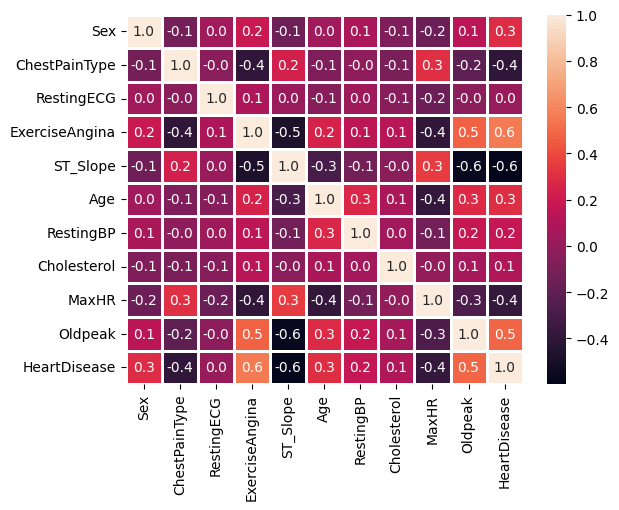

In [20]:
df_corr = df.corr()
sns.heatmap(df_corr,annot=True,fmt='.1f',linewidths=1)

In [42]:
scalar = MinMaxScaler()
df_scaled = scalar.fit_transform(df)

In [43]:
df = pd.DataFrame(df_scaled, columns=df.columns)

df

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease
0,1.0,0.333333,0.5,0.0,1.0,0.244898,0.615385,0.691120,0.774436,0.027027,0.0
1,0.0,0.666667,0.5,0.0,0.5,0.428571,0.871795,0.270270,0.654135,0.297297,1.0
2,1.0,0.333333,1.0,0.0,1.0,0.183673,0.487179,0.667954,0.218045,0.027027,0.0
3,0.0,0.000000,0.5,1.0,0.5,0.408163,0.589744,0.401544,0.293233,0.432432,1.0
4,1.0,0.666667,0.5,0.0,1.0,0.530612,0.743590,0.328185,0.398496,0.027027,0.0
...,...,...,...,...,...,...,...,...,...,...,...
741,1.0,1.000000,0.5,0.0,0.5,0.346939,0.230769,0.594595,0.473684,0.351351,1.0
742,1.0,0.000000,0.5,0.0,0.5,0.816327,0.666667,0.320463,0.541353,0.945946,1.0
743,1.0,0.000000,0.5,1.0,0.5,0.591837,0.487179,0.081081,0.345865,0.351351,1.0
744,0.0,0.333333,0.0,0.0,0.5,0.591837,0.487179,0.486486,0.789474,0.027027,1.0


In [44]:
input_ = df.drop(['HeartDisease'],axis=1)
target = df['HeartDisease']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(input_, target, test_size=.2, random_state=42)

In [46]:
print(X_test.shape)
X_train.shape

(150, 10)


(596, 10)

In [47]:
lc = LogisticRegression()
svm_ = SVC(kernel='poly',C=1.0)
knn = KNeighborsClassifier()
ada = AdaBoostClassifier(n_estimators=90, learning_rate=1.0)
bagging = BaggingClassifier(n_estimators=70, max_samples=1.0, max_features=1.0)
extra = ExtraTreesClassifier(n_estimators=100, criterion='gini', max_depth=6)
Gradient = GradientBoostingClassifier(n_estimators=50)
dici = DecisionTreeClassifier()
random = RandomForestClassifier(n_estimators=200,  criterion='gini', max_depth=6, min_samples_split=2)
xgb = XGBClassifier()

In [48]:
def model (model): 
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test)  
    
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {model.score(X_train ,y_train)}")  
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    corr = confusion_matrix(y_test, y_pred)
    sns.heatmap(corr,annot=True,fmt='1.1f')
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86        71
         1.0       0.89      0.84      0.86        79

    accuracy                           0.86       150
   macro avg       0.86      0.86      0.86       150
weighted avg       0.86      0.86      0.86       150

Accuracy: 0.8456375838926175
Confusion Matrix:
[[63  8]
 [13 66]]
Accuracy Score: 0.86


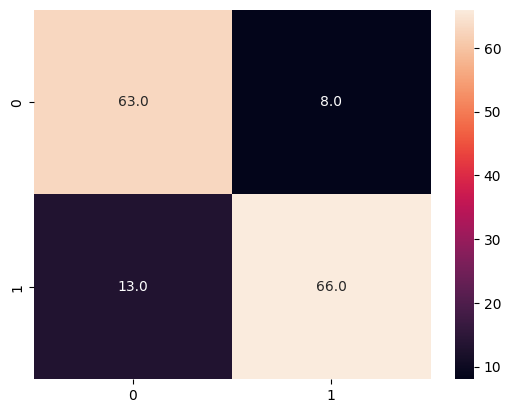

In [49]:
model(lc)

              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86        71
         1.0       0.90      0.84      0.87        79

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.87      0.87      0.87       150

Accuracy: 0.8926174496644296
Confusion Matrix:
[[64  7]
 [13 66]]
Accuracy Score: 0.8666666666666667


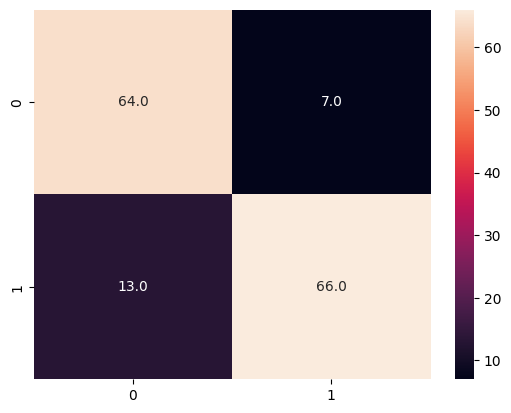

In [50]:
model(svm_)

              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88        71
         1.0       0.91      0.87      0.89        79

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150

Accuracy: 0.8842281879194631
Confusion Matrix:
[[64  7]
 [10 69]]
Accuracy Score: 0.8866666666666667


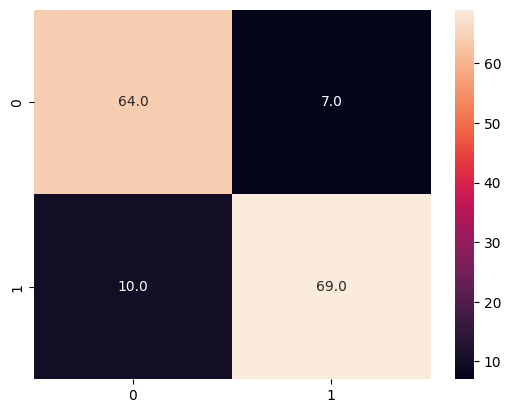

In [51]:
model(knn)

              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86        71
         1.0       0.89      0.84      0.86        79

    accuracy                           0.86       150
   macro avg       0.86      0.86      0.86       150
weighted avg       0.86      0.86      0.86       150

Accuracy: 0.8825503355704698
Confusion Matrix:
[[63  8]
 [13 66]]
Accuracy Score: 0.86


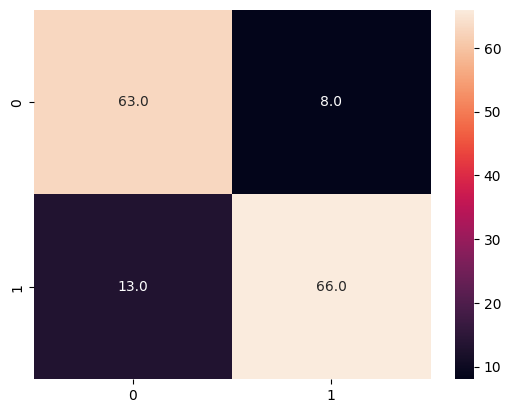

In [52]:
model(ada)

              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87        71
         1.0       0.93      0.81      0.86        79

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.87      0.87      0.87       150

Accuracy: 1.0
Confusion Matrix:
[[66  5]
 [15 64]]
Accuracy Score: 0.8666666666666667


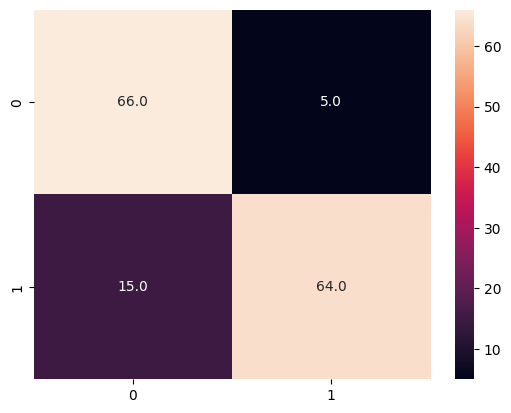

In [53]:
model(bagging)

              precision    recall  f1-score   support

         0.0       0.86      0.92      0.88        71
         1.0       0.92      0.86      0.89        79

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150

Accuracy: 0.9077181208053692
Confusion Matrix:
[[65  6]
 [11 68]]
Accuracy Score: 0.8866666666666667


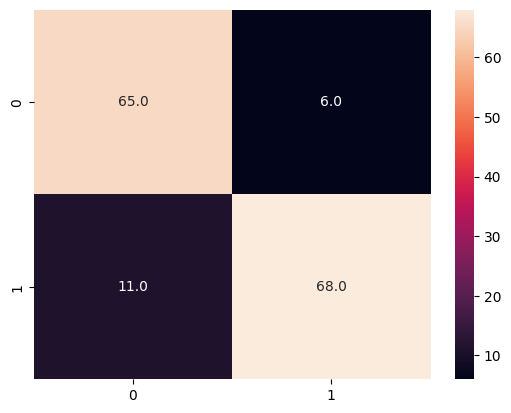

In [54]:
model(extra)

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90        71
         1.0       0.92      0.89      0.90        79

    accuracy                           0.90       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.90      0.90      0.90       150

Accuracy: 0.9228187919463087
Confusion Matrix:
[[65  6]
 [ 9 70]]
Accuracy Score: 0.9


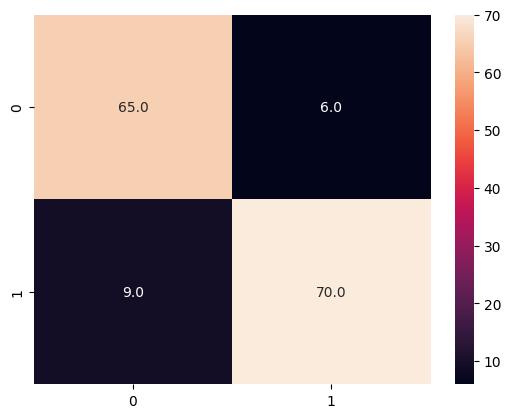

In [55]:
model(Gradient)

              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85        71
         1.0       0.90      0.81      0.85        79

    accuracy                           0.85       150
   macro avg       0.86      0.86      0.85       150
weighted avg       0.86      0.85      0.85       150

Accuracy: 1.0
Confusion Matrix:
[[64  7]
 [15 64]]
Accuracy Score: 0.8533333333333334


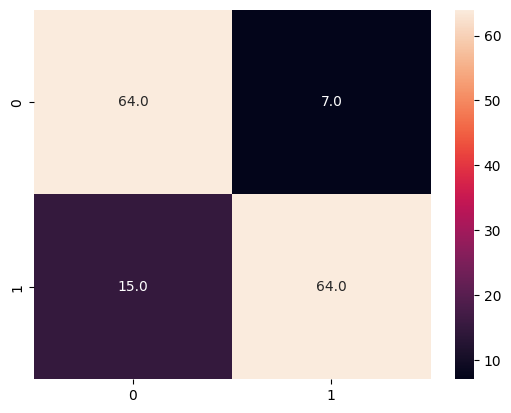

In [56]:
model(dici)

              precision    recall  f1-score   support

         0.0       0.86      0.92      0.88        71
         1.0       0.92      0.86      0.89        79

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150

Accuracy: 0.9345637583892618
Confusion Matrix:
[[65  6]
 [11 68]]
Accuracy Score: 0.8866666666666667


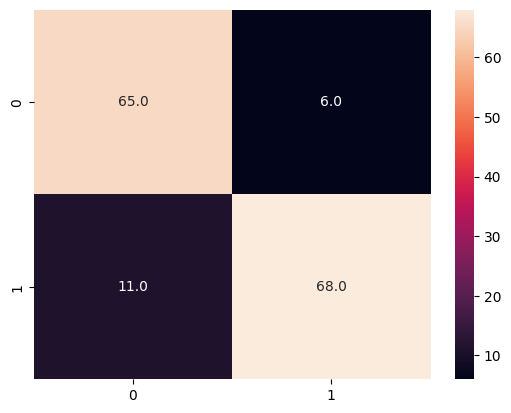

In [57]:
model(random)

              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89        71
         1.0       0.93      0.86      0.89        79

    accuracy                           0.89       150
   macro avg       0.89      0.90      0.89       150
weighted avg       0.90      0.89      0.89       150

Accuracy: 1.0
Confusion Matrix:
[[66  5]
 [11 68]]
Accuracy Score: 0.8933333333333333


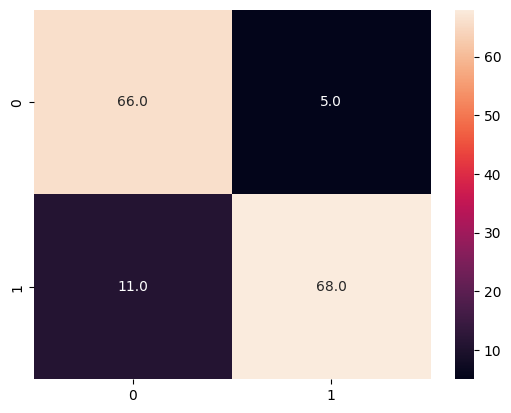

In [58]:
model(xgb)

In [59]:
model = Sequential([
    Dense(128,activation='relu',input_dim =X_train.shape[1]),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),

    Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
model.fit(X_train,y_train,epochs=50)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6860 - loss: 0.6635
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.8279 - loss: 0.4947
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8331 - loss: 0.4027  
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.8689 - loss: 0.3377
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.8385 - loss: 0.3572
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.8241 - loss: 0.3877
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.8585 - loss: 0.3572
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.8520 - loss: 0.3567
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accuracy: 0.8446 - loss: 0.3748
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accuracy: 0.8299 - loss: 0.3674
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.8718 - loss: 0.3193
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - a

In [61]:
model.evaluate(X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9041 - loss: 0.2828


[0.3040408492088318, 0.8933333158493042]

In [62]:
import joblib

joblib.dump(model, 'heart_model.pkl')

joblib.dump(scalar, 'scalar.pkl')


['scalar.pkl']